In [1]:
import codebase.web_scrape_functions as wsf
import codebase.analysis_functions as af
import codebase.match_data as match_data
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import utils
from utils import logger
import os
import logging
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import codebase.graphing_functions as gf
from codebase.settings import CAREERS
from codebase.settings import LABEL_DATA

if utils.check_if_ipython():
    logger.disabled = True

%load_ext autoreload
%autoreload 2
logger.handlers[1].setLevel(logging.INFO)
# logger.disabled = True
pd.get_option("display.max_columns")

d:\Documents\Cricket\data_analysis\cricket_analytics\data\cricket_data.db


20

First step is to get Kohli's career averges for all shots, then his averages for just specific shots and then we can find his most productive shot. The problem with searching things based off of specific shots strings only is that there is a veriety in the way that shots are described in the commentary. We would need a machine learning algorithm to work and recognize what these shots are. But first we need to create a training set which is a pain in the ass.

In [2]:
KOHLI_ID = '253802'
ROOT_PLAYER_ID = '303669'
WILLIAMSON_PLAYER_ID = '277906'
SPD_SMITH_ID = '267192'

In [3]:
kohli_matches = wsf.get_player_match_list(KOHLI_ID)

In [4]:
kohli_innings = af.get_cricket_totals(KOHLI_ID, kohli_matches, _type='bat', by_innings=True, is_object_id=True, from_scorecards=False)

In [5]:
kohli_comms = af.get_player_contributions(KOHLI_ID, kohli_matches, _type='bat', by_innings=True, is_object_id=True)

In [6]:
kohli_comms_flat = [x for comms in kohli_comms for x in comms.commentTextItems.to_list()]

In [6]:
def search_shots_in_comms(contributions, search_keywords, exlude_words=[], primary_keywords=[], threshold = 0.5):
    shots = []
    for i, comms in enumerate(contributions):
        innings = comms.commentTextItems.to_list()
        search = af.search_for_phrases(innings, keywords=search_keywords, exclude_words=exlude_words, primary_keywords=primary_keywords, threshold = threshold)
        shots.append(comms.iloc[[i for i,x in enumerate(search[0]) if x == 1]])
        
    return shots

In [6]:
## Cover drives 
cover_drive_primary_kw = ['cover drive', 'cover-drive']

cover_drive_search_kw = [
    'drive',
    ('punch', 0.3),
    ('cover', 0.3),
    ('full', 0.2),
    ('wide', 0.2) ,
    ('widish', 0.2),
    'outside edge',
    ('reach', 0.3),
    'slip',
    'edge',
    'driving'
]
cover_drive_exlude_words = [
    'run out',
    'pull', 'flick',
    'bouncer', 'short ball', 'stays back',
    'backfoot', 'top edge', 'leave',
    'lets one go', 'easy leave', 'leaves the ball',
    'leg side', 'leading edge', 'leg ', 'cut', 'leg.',
    'on the pads', 'left alone', ('short', 0.25)
]


In [7]:
cover_drive_primary_kw = ['cover drive', 'cover-drive']

cover_drive_search_kw = [
    'drive',
    ('punch', 0.3),
    ('cover', 0.3),
    ('off side', 0.2),
    ('full', 0.25),
    ('wide', 0.2) ,
    ('outside edge', 0.3),
    ('reach', 0.3),
    ('slip', 0.25),
    ('edge', 0.3),
    'driving',
    ('force', 0.2),
    ('push', 0.3),
    ('pitched up', 0.3),
    ('Overpitched', 0.2),
    ('dab', 0.2),
    ('outside off', 0.25)

]
cover_drive_exlude_words = [
    'run out',
    'pull', 'flick',
    'bouncer', 'short ball', 'stays back',
    'backfoot', 'top edge', 'leave', 'back foot', ('back', 0.2),
    'lets one go', 'easy leave', 'leaves the ball', 'goes back',
    'leg side', 'leading edge', ('leg ', 0.25), 'cut', ('leg', 0.25),
    'on the pads', 'left alone', ('short', 0.25), ('midwicket', 0.2), ('long-on', 0.25), ('long on', 0.25), ('back of a length', 0.25)
]



In [10]:
ind, scores = af.search_for_phrases(kohli_comms_flat, cover_drive_search_kw, cover_drive_exlude_words, primary_keywords=cover_drive_primary_kw, threshold=0.49)
cover_drives_career = [kohli_comms_flat[i] for i,x in enumerate(ind) if x==1]
cover_drives_almost = [kohli_comms_flat[i] for i,x in enumerate(scores) if x < 0.49 and x > 0]

In [11]:
print(len(cover_drives_career))
cover_drives_career

2682


["And it wasn't long coming, virat brings out the whiplash extra cover drive off a fuller one but cannot beat the infield",
 "That is the end of virat's debut innings, he is gone nibbling at one outside off and baugh has gobbled up the appetiser before lunch, was some distance from virat, not much need to play at it, but for once virat pressed forward, and got so close to the ball that he had to play at it, and ended up getting a healthy edge through to the keeper, a happy bunch of west indians will take lunch,",
 'Driven to bravo at cover',
 'Uppishly into the leg side, wide of short midwicket, early into the shot as he looked to cover-drive',
 'Punched away to cover',
 'Brute! absolute brute. hits a crack on a length, and jumps at his, beating his drive. dravid comes up and has a word with him',
 'Nice inside-out drive wide of mid-off for one',
 'In-between length, pushed away to cover',
 "This one doesn't quite come up, it's outside off, but a somewhat flustered kohli plays at it, a

In [12]:
print(len(cover_drives_almost))
cover_drives_almost[1000:]

3093


['Hits the pad on the forward defensive as kohli tries to defend a tossed up ball outside off',
 'Gets forward and defends, the ball runs along the ground wide of slip',
 'Digs out a full one slanted full across him, to mid off',
 'This is wide, and kohli has guided it behind point, it is a long chase but it is stopped inside',
 'Good length ball turning in from outside off, defended',
 'Stretches forward to a good length ball outside off and defends',
 'Good length ball outside off stump, easily blocked',
 'Tossed up outside off stump, defended',
 'Comes forward to smother this one outside off',
 'On the front foot solidly to defend to short extra cover',
 'Overpitched, kohli checks his push to mid off',
 'Touch fuller, but he can go right back to defend',
 'Closes the face as he comes forward to push to mid off',
 'Good length coming in a bit, pushed to mid on',
 'Starts good length outside off after drinks, kohli defends without any issues',
 'Bounce from a length outside off, he wa

In [13]:
cover_drives_played = search_shots_in_comms(kohli_comms, cover_drive_search_kw, cover_drive_exlude_words, primary_keywords=cover_drive_primary_kw)

In [14]:
cover_drive_averages, cover_drive_totals, cover_drive_stats = af.analyse_batting(cover_drives_played)

In [15]:
cover_drive_averages

{'runs': 13.3,
 'dismissals': 0.29,
 'balls': 15.45,
 'sr': 0.72,
 'average': nan,
 'dot_balls': 9.3,
 'ones': 3.22,
 'twos': 0.76,
 'threes': 0.28,
 'fours': 1.91,
 'fives': 0.0,
 'sixes': 0.01,
 'total_balls_faced': 80.17,
 'fours_per_ball': 0.1,
 'sixes_per_ball': 0.0,
 'dots_per_ball': 0.59}

In [16]:
cover_drive_totals

{'runs': 2301,
 'dismissals': 51,
 'balls': 2673,
 'sr': 125.12000000000002,
 'average': nan,
 'dot_balls': 1609,
 'ones': 557,
 'twos': 132,
 'threes': 48,
 'fours': 331,
 'fives': 0,
 'sixes': 2,
 'total_balls_faced': 13869.0,
 'fours_per_ball': 17.790000000000006,
 'sixes_per_ball': 0.060000000000000005,
 'dots_per_ball': 101.23999999999998}

In [8]:
flick_primary_kw = [
    'flick'
]
flick_search_kw = [
    'tuck',
    'clipped',
    'clip',
    ('pads', 0.3),
    ('pad ', 0.3),
    'on the pads',
    #('leg side', 0.25),
    ('leg', 0.3),
    ('square', 0.19),
    'glance'
    'off the pads',
    'off his pads',
    ('nudge', 0.3),
    ('pick', 0.3),
    ('straight', 0.3),
    #('square leg', 0.25),
    ('whip', 0.4),
    'on the legs',
    ('work', 0.25),
    ('midwicket', 0.3),
    ('on side', 0.25),
    ('across', 0.3)
]
flick_exlude_words = [
    'run out', 'bumper', 'sweep', 'swept',
    'pull', 'drive', 'cover-drive', ('cover', 0.3),
    'bouncer', 'short ball', 'stays back',
    'backfoot', 'top edge',
    'lets one go', 'easy leave', 'leaves the ball', 'padded away',
    ('off side', 0.25), 'cut', 'left alone', ('point', 0.25), ('defend', 0.3), ('push', 0.25)
]



In [ ]:
flick_shots_career = search_shots_in_comms(kohli_comms, flick_search_kw, flick_exlude_words, flick_primary_kw, threshold=0.49)

In [18]:
flick_averages, flick_totals, flick_stats = af.analyse_batting(flick_shots_career)

In [19]:
flick_averages
#Flicks mostly produce singles from Kohli, there are almost as many ones as there are dots with flicks, so this is a genrally 'safe' shot for Kohli which is quite productive.

{'runs': 12.75,
 'dismissals': 0.2,
 'balls': 14.21,
 'sr': 0.84,
 'average': nan,
 'dot_balls': 6.11,
 'ones': 5.58,
 'twos': 1.33,
 'threes': 0.27,
 'fours': 0.91,
 'fives': 0.0,
 'sixes': 0.01,
 'total_balls_faced': 78.71,
 'fours_per_ball': 0.07,
 'sixes_per_ball': 0.0,
 'dots_per_ball': 0.41}

In [20]:
flick_totals

{'runs': 2205,
 'dismissals': 35,
 'balls': 2459,
 'sr': 144.6500000000001,
 'average': nan,
 'dot_balls': 1057,
 'ones': 966,
 'twos': 230,
 'threes': 47,
 'fours': 158,
 'fives': 0,
 'sixes': 1,
 'total_balls_faced': 13616.0,
 'fours_per_ball': 12.229999999999999,
 'sixes_per_ball': 0.03,
 'dots_per_ball': 70.72000000000001}

In [26]:
pull_primary_kw = ['short-arm jab']

pull_search_kw = [
    'pull',
    'hook',
    ('short', 0.2),
    ('back foot', 0.2),
    ('swivel', 0.3),
    ('bouncer', 0.2),
    ('bumper', 0.2),
    ('hammer', 0.3),
    ('slam',  0.3),
    ('slap',  0.3),
    ('thump', 0.3),
    ('smash', 0.3),
    ('pummels', 0.3)
    #Add club
]
pull_exlude_words = [
    'full',
    'cut',
    'flick',
    'drive',
    'push',
    'block',
    'outside edge',
    ('cover', 0.3),
    ('pads', 0.3), ('off side', 0.25), ('point', 0.25),
    'lets one go', 'easy leave', 'leaves the ball', 'left alone', 'lets it go', 'inside edge'
    
]

In [22]:
pull_ind, pull_scores = af.search_for_phrases(kohli_comms_flat, pull_search_kw, pull_exlude_words, primary_keywords=pull_primary_kw, threshold=0.49)
pulls_career = [(kohli_comms_flat[i], i) for i,x in enumerate(pull_ind) if x==1]
pulls_almost = [(kohli_comms_flat[i], i) for i,x in enumerate(pull_scores) if x < 0.49 and x > 0]

In [23]:
pulls_career

[('Long hop to end the over, kohli latches on with the pull but edwards does well to dive at midwicket and save the boundary.',
  138),
 ('Pulled away to deep square, retains strike', 244),
 ("First boundary since sehwag's dismissal. this is a long hop, asking to be hit,. kohli obliges by going back and pulling it over midwicket. which also shows india haven't gone into a shell. they are cautious but still awake to rank bad deliveries",
  364),
 ("Short ball, across him, kohli pulls it, wide of mid-on, but can't find the gap",
  397),
 ("A long hop, and he has pulled this smack into barath's shoulder at forward short leg. that could have gone for four. that ricochet could have lobbed for a catch. to borrow from bill lawry, it's all happening",
  400),
 ("Misfield. short of a length, pulled away from outside off, through bishoo at short midwicket. didn't go down properly. that injury must bothering him",
  413),
 ('Too short, kohli goes deep into the crease to pull this along the ground

In [24]:
pulls_almost

[('There arrives the short ball, but a touch outside off stump and virat calmly weaves out of its path',
  6),
 ('Pitches leg, turns away, but it slightly short, and kohli deals easily off the back foot',
  31),
 ('Bouncer, too short really, easy for kohli to duck under', 34),
 ('Good bouncer, in the chest-throat area, fended past short leg', 41),
 ('This bouncer bounces as high as expected, and he can duck under it', 43),
 ("Wasted bouncer, down the leg side, easy to stay out of harm's way here",
  44),
 ('Short, kohli fends with the bottom hand off, straight into the ground. more staring',
  45),
 ("Oversteps striving for extra once, as it turns out this is too short and kohli easily ducks under it. actually no-ball called from square leg because there were three fielders behind square on the on side. two fielders in the deep and barath's one foot was behind the crease at short leg",
  46),
 ("That's poorly judged by barath at short leg. fidel has kohli fending, the ball lobs and fal

In [25]:
pull_shots_career = search_shots_in_comms(kohli_comms, pull_search_kw, pull_exlude_words, primary_keywords=pull_primary_kw, threshold=0.49)
pull_averages, pull_totals, pull_stats = af.analyse_batting(pull_shots_career)

In [26]:
pull_averages

{'runs': 3.58,
 'dismissals': 0.03,
 'balls': 2.0,
 'sr': 0.98,
 'average': nan,
 'dot_balls': 0.57,
 'ones': 0.65,
 'twos': 0.15,
 'threes': 0.02,
 'fours': 0.58,
 'fives': 0.0,
 'sixes': 0.04,
 'total_balls_faced': 55.41,
 'fours_per_ball': 0.16,
 'sixes_per_ball': 0.01,
 'dots_per_ball': 0.18}

In [27]:
pull_totals

{'runs': 620,
 'dismissals': 5,
 'balls': 346,
 'sr': 169.6,
 'average': nan,
 'dot_balls': 98,
 'ones': 113,
 'twos': 26,
 'threes': 3,
 'fours': 101,
 'fives': 0,
 'sixes': 7,
 'total_balls_faced': 9586.0,
 'fours_per_ball': 28.389999999999993,
 'sixes_per_ball': 1.3,
 'dots_per_ball': 31.12}

In [27]:
cut_primary_kw = [
]
cut_search_kw = [
    ('cut', 0.6),
    ('point', 0.4),
    ('guide', 0.3),
    ('cover', 0.1),
    ('third man', 0.2),
    ('short', 0.2),
    ('wide', 0.2),
    ('bouncer', 0.2),
    ('bumper', 0.3)
    
]
cut_exlude_words = [
    'full', 'pull', 'hook', 'flick', 'drive', ('leg', 0.3), ('pads', 0.3), ('cut'), 'defend', 'defensive', 'leaving alone',
    'lets one go', 'easy leave', 'leaves the ball', 'left alone', 'pitching', 'lets it go', 'inside edge', ('cutter', 0.3), 'pitched up'
]

In [29]:
cut_ind, cut_scores = af.search_for_phrases(kohli_comms_flat, cut_search_kw, cut_exlude_words, primary_keywords=cut_primary_kw, threshold=0.55)
cuts_career = [(kohli_comms_flat[i],i) for i,x in enumerate(cut_ind) if x==1]
cuts_almost = [(kohli_comms_flat[i],i) for i,x in enumerate(cut_scores) if x < 0.55 and x > 0]

In [30]:
cuts_career

[('Turns away from a shortish length and virat goes back to push it towards point',
  1),
 ('Short of a length outside off, kohli stays back and looks to guide through backward point.,',
  94),
 ('Short of a length outside off, kohli guides easily through covers for a single.',
  121),
 ('This one breaks away from kohli as he leans out, and he adjusts to guide the push into the point area.',
  128),
 ('Bishoo keeps it short of a length outside off, and kohli works it towards cover point.',
  153),
 ('Goes on the back foot to guide it towards backward point', 202),
 ('Short of a length, outside off, pushed to deep point to get to his personal best. the distance to the follow-on mark under 20 now',
  294),
 ('Shorter ball this time, just outside off, kohli controls that one well, jumps to get on top of the bounce and taps the ball towards point',
  309),
 ('Shorter and well outside off, slashed towards deep point for a single',
  322),
 ('Length ball just outside off, guided towards back

In [31]:
cuts_almost

[('There arrives the short ball, but a touch outside off stump and virat calmly weaves out of its path',
  6),
 ('Gets behind a short of a length ball and blocks it back to the bowler', 7),
 ('Punched away to cover', 17),
 ('Stays back of a length, kohli wants a quick single but he has hit it straight to cover',
  28),
 ('In-between length, pushed away to cover', 33),
 ('Bouncer, too short really, easy for kohli to duck under', 34),
 ('Wide of the crease, a length ball angled in, kohli is solid in defence',
  36),
 ('Good bouncer, in the chest-throat area, fended past short leg', 41),
 ('This bouncer bounces as high as expected, and he can duck under it', 43),
 ('Short, kohli fends with the bottom hand off, straight into the ground. more staring',
  45),
 ('Quick quick bouncer, 92.2mph, off-stump line, and kohli drops his wrists and sways out of its line',
  50),
 ('Right behind this one, drops it towards cover', 58),
 ('Nicely guided past the hobbling bishoo at mid-on', 59),
 ('Wide o

In [32]:
cut_shots_career = search_shots_in_comms(kohli_comms, cut_search_kw, cut_exlude_words, primary_keywords=cut_primary_kw, threshold=0.55)
cut_averages, cut_totals, cut_stats = af.analyse_batting(cut_shots_career)

In [33]:
cut_averages

{'runs': 1.52,
 'dismissals': 0.0,
 'balls': 1.41,
 'sr': 0.55,
 'average': nan,
 'dot_balls': 0.57,
 'ones': 0.52,
 'twos': 0.13,
 'threes': 0.03,
 'fours': 0.16,
 'fives': 0.0,
 'sixes': 0.0,
 'how-out': 0.0,
 'total_balls_faced': 50.02,
 'fours_per_ball': 0.07,
 'sixes_per_ball': 0.0,
 'dots_per_ball': 0.22}

In [34]:
cut_totals

{'runs': 263,
 'dismissals': 0,
 'balls': 244,
 'sr': 94.95,
 'average': nan,
 'dot_balls': 98,
 'ones': 90,
 'twos': 23,
 'threes': 5,
 'fours': 28,
 'fives': 0,
 'sixes': 0,
 'how-out': 0,
 'total_balls_faced': 8654.0,
 'fours_per_ball': 11.64,
 'sixes_per_ball': 0.0,
 'dots_per_ball': 38.830000000000005}

In [28]:
sweep_primary_kw = [
]
sweep_search_kw = [
    'paddle',
    'sweep',
    
]
sweep_exlude_words = [
    'sweeper', 'drive', 'cut', 'flick', 'pull'
]

In [36]:
sweep_ind, sweep_scores = af.search_for_phrases(kohli_comms_flat, sweep_search_kw, sweep_exlude_words, primary_keywords=sweep_primary_kw, threshold=0.49)
sweep_career = [(kohli_comms_flat[i],i) for i,x in enumerate(sweep_ind) if x==1]
sweep_almost = [(kohli_comms_flat[i],i) for i,x in enumerate(sweep_scores) if x < 0.49 and x > 0]

In [37]:
sweep_career

[('Attacking sweep shot from a straight line to deep backward square. bounces once before it reaches the fielder',
  3644),
 ('Length and outside off, kohli watches the ball carefully, weathers a bit of extra bounce and he gets a top edge that goes to the  square leg boundary. unconvincing sweep',
  3914),
 ("Top edge to the sweep, but it doesn't carry to short fine leg. lyon's bounce is troubling everyone, as our experts said",
  3922),
 ("Nails the sweep this time and he's found the square leg boundary. seemed a touch too full and just enough room, kohli's strong bottom hand took care of the challenge very well.",
  3932),
 ("Carted it over the leg side infield! it's pretty well populated there with midwickets and square legs and fine legs, but he sends it soaring over all of them with a powerful slog sweep. and even that has a whip to it!",
  3984),
 ('Flighted outside off, kohli looks to sweep and gets struck on the helmet. bounces off the grille to short fine leg',
  3994),
 ("Fli

In [38]:
sweep_almost

[]

In [39]:
sweep_shots_career = search_shots_in_comms(kohli_comms, sweep_search_kw, sweep_exlude_words, primary_keywords=sweep_primary_kw, threshold=0.49)
sweep_averages, sweep_totals, sweep_stats = af.analyse_batting(sweep_shots_career)

In [40]:
len(sweep_shots_career)

173

In [41]:
sweep_averages

{'runs': 0.45,
 'dismissals': 0.02,
 'balls': 0.24,
 'sr': 0.22,
 'average': nan,
 'dot_balls': 0.1,
 'ones': 0.03,
 'twos': 0.02,
 'threes': 0.01,
 'fours': 0.08,
 'fives': 0.0,
 'sixes': 0.01,
 'total_balls_faced': 15.97,
 'fours_per_ball': 0.04,
 'sixes_per_ball': 0.01,
 'dots_per_ball': 0.05}

In [42]:
sweep_totals

{'runs': 77,
 'dismissals': 4,
 'balls': 42,
 'sr': 37.42,
 'average': nan,
 'dot_balls': 17,
 'ones': 6,
 'twos': 3,
 'threes': 1,
 'fours': 14,
 'fives': 0,
 'sixes': 1,
 'total_balls_faced': 2763.0,
 'fours_per_ball': 6.53,
 'sixes_per_ball': 1.0,
 'dots_per_ball': 9.39}

In [20]:
backfoot_drive_primary_kw = [
]
backfoot_drive_kw = [
    ('(?:back foot){1,}[\s\w]{0,}drive'),
    ('drive[\s\w]{0,}(?:back foot){1,}'),
    ('(?:back foot){1,}[\s\w]{0,}driving'),
    ('driving[\s\w]{0,}(?:back foot){1,}'),
    ('back foot'),
    ('punch', 0.2), #
    #('cover', 0.3),
    #('off side', 0.2),
    ('(?:goes|stays|gets|rocks|go|step)[\s]{0,1}[\w]{0,} back'),
    #('goes back', 0.3), ('stays back', 0.3), ('gets back', 0.3), ('rocks back', 0.3), ('go back', 0.3),
    ('short', 0.3),
    ('back of a length', 0.3),
    #('(?:short|back) of a length', 0.3),
    #('outside edge', 0.3),
    #('reach', 0.3),
    #('slip', 0.25),
    #('edge', 0.3),
    ('driving', 0.3),
    ('force', 0.2),
    ('push', 0.2),
    ('waft', 0.2),
    ('poke', 0.2),
    ('carve', 0.2),
    #('dab', 0.2),
    ('(?:short)[\s]{0,1}[\w]{0,} outside[\s]{0,1}[\w]{0,}off', 0.25),
    ('outside[\s]{0,1}[\w]{0,}off[\s]{0,1}[\w]{0,}(?:short)', 0.25)
    #ADD Guides off the backfoot
    #ADD Guides through covers
    #Drops it on the off side cover
    
]
backfoot_drive_exclude_words = [
    'run out', 'over-pitched', 'overpitched', 'pitched up',
    'pull', 'flick', 'whip', ('duck', 0.5), ('pads', 0.3), 'tuck', ('short (?:cover|midwicket|extra-cover)', 0.3),
    'forward', ('square leg', 0.3), ('on the up', 0.3), 'block', 'on side',
    'full toss', ('full', 0.8), 'comes forward', 'defend', 'defens', 'defence', ('guide[\s\w]{0,}(?:point|third man){1,}'), ('dab[\s\w]{0,}(?:point|third man){1,}'),
    'top edge', 'leave', 'front foot', ('front', 0.2), ('clip', 0.3), ('work[\s\w]{0,}(?:leg|midwicket|deep square|on side){1,}', 0.2),
    'lets one go', 'easy leave', 'leaves the ball', 'goes forward', ('short leg', 0.3),
    'leg side', 'leading edge', ('leg', 0.3), 'cut', ('leg', 0.25), 'weave', 'plays across',
    'on the pads', 'left alone', ('midwicket', 0.3), ('long-on', 0.25), ('long on', 0.25)
]


In [44]:
backfoot_drive_ind, backfoot_drive_scores = af.search_for_phrases(kohli_comms_flat, backfoot_drive_kw, backfoot_drive_exclude_words, primary_keywords=backfoot_drive_primary_kw, threshold=0.49)
backfoot_drive_career = [(kohli_comms_flat[i],i, backfoot_drive_scores[i]) for i,x in enumerate(backfoot_drive_ind) if x==1]
backfoot_drive_almost = [(kohli_comms_flat[i],i, x) for i,x in enumerate(backfoot_drive_scores) if x < 0.49 and x > 0]

In [45]:
backfoot_drive_career

[('Turns away from a shortish length and virat goes back to push it towards point',
  1,
  1),
 ('Back of a length, sharp, outside off, pushed to off', 27, 0.5),
 ('Stays back of a length, kohli wants a quick single but he has hit it straight to cover',
  28,
  0.8),
 ('Another short one, now that he has thrown a punch, kohli decides to go back to ducking under it.',
  85,
  0.5),
 ('Flat from bishoo, kohli goes back and forces it towards wide mid-on. laxman trots across serenely for the single, and is in some strife as the throw comes in, but he is safe.',
  99,
  0.7),
 ("Short of a length from sammy, who is looking to hold up an end till the new ball is taken, i reckon. kohli doesn't try to force the issue.",
  130,
  0.5),
 ('A confident start from kohli, punching bishoo off the back foot through covers',
  173,
  0.7),
 ("Shot, chanders has had to a lot of chasing today, mid on is shortish, virat's push-drive easily beats him and it is up to chanders to go after it from mid off",


In [46]:
backfoot_drive_almost

[('Punched away to cover', 17, 0.2),
 ('Pitches leg, turns away, but it slightly short, and kohli deals easily off the back foot',
  31,
  0.25),
 ('In-between length, pushed away to cover', 33, 0.2),
 ('Short, kohli fends with the bottom hand off, straight into the ground. more staring',
  45,
  0.3),
 ('Rampaul has taken off, his team-mates rush after him, virat has been bounced out, nothing shot, nothing at all actually, just caught on the crease shuffling across, he was probably expecting the bouncer as he was crouching a tad, instead rampaul gets it to shoot off from back of a length and straighten as well, and before virat could do anything, the ball had taken the glove and lobbed high to second slip',
  65,
  0.3),
 ('Another bouncer, too short though and not the best line either. well outside off and kohli gets under it.',
  67,
  0.3),
 ("Short and spicy, 88 mph and thudding into kohli's bat close to his handle. fended into the off side.",
  81,
  0.3),
 ("Kohli wisely takes a

In [47]:
len(backfoot_drive_career)

504

In [51]:
backfoot_drive_career_shots = search_shots_in_comms(kohli_comms, backfoot_drive_kw, backfoot_drive_exclude_words, primary_keywords=backfoot_drive_primary_kw, threshold=0.49)
backfoot_drive_averages, backfoot_drive_totals, backfoot_drive_stats = af.analyse_batting(backfoot_drive_career_shots)

In [52]:
backfoot_drive_averages

{'runs': 1.61,
 'dismissals': 0.03,
 'balls': 2.91,
 'sr': 0.41,
 'average': nan,
 'dot_balls': 1.83,
 'ones': 0.82,
 'twos': 0.12,
 'threes': 0.05,
 'fours': 0.1,
 'fives': 0.0,
 'sixes': 0.0,
 'total_balls_faced': 63.43,
 'fours_per_ball': 0.03,
 'sixes_per_ball': 0.0,
 'dots_per_ball': 0.44}

In [53]:
backfoot_drive_totals

{'runs': 279,
 'dismissals': 5,
 'balls': 504,
 'sr': 70.59,
 'average': nan,
 'dot_balls': 316,
 'ones': 141,
 'twos': 21,
 'threes': 8,
 'fours': 18,
 'fives': 0,
 'sixes': 0,
 'total_balls_faced': 10973.0,
 'fours_per_ball': 4.550000000000001,
 'sixes_per_ball': 0.0,
 'dots_per_ball': 75.39}

In [29]:
test_drive_ind, test_drive_scores = af.search_for_phrases(['Lovely punch by kohli, boult was bowling round the wicket, landed it a touch too wide and kohli used the crease well to slam it past cover'], cover_drive_search_kw, cover_drive_exlude_words, primary_keywords=cover_drive_primary_kw, threshold=0.49)
test_drive_scores

[0.8]

Ok now that we have a list of the cover drives that Kohli has played, we want to find out if there is a batter in cover drives between times when he was in good form and times when he was not. So what we actually want to do is first find the cover drives played in each innings of Kohli's career. We also want to know what ball in the innings that particular shot is, and we also want to know the runs scored off that particular delivery. We then want to create a graph with two bars, one that shows total runs in each inning, and one that shows the runs from the particular shot in the inning.

The appraoch in this case will be. 
1. Find the cover drives in each inning, going inning by inning. 
2. Create a dataframe with only the cover drives in each inning
3. Get the cricket totals from these dfs
4. Then graph the total runs in the innings and also ones from just the shot.

**Getting cover drives in all the innings**

In [9]:
kohli_coverdrive_comms = search_shots_in_comms(kohli_comms, cover_drive_search_kw, cover_drive_exlude_words, cover_drive_primary_kw, threshold=0.49)

In [10]:
cover_drive_innings = []

for inning in kohli_coverdrive_comms:
    try:
        cover_drive_innings.append(af.analyse_batting_inning(inning))
    except IndexError:
        cover_drive_innings.append(
            {
                'runs': 0,
                'dismissals': 0,
                'balls': 0,
                'sr': 0,
                'average': 0,
                'dot_balls': 0,
                'ones': 0, 
                'twos': 0,
                'threes': 0, 
                'fours': 0,
                'fives': 0,
                'sixes': 0,
                'how-out': None,
                'total_balls_faced': 0,
                'fours_per_ball': 0,
                'sixes_per_ball': 0,
                'dots_per_ball': 0
            }
        )

In [11]:
kohli_cover_drive_stats = [af.analyse_batting_inning(inning) for inning in kohli_coverdrive_comms]

In [12]:
kohli_cover_drive_stats[2]

{'runs': 0,
 'dismissals': False,
 'balls': 0,
 'sr': nan,
 'average': nan,
 'dot_balls': 0,
 'ones': 0,
 'twos': 0,
 'threes': 0,
 'fours': 0,
 'fives': 0,
 'sixes': 0,
 'how-out': False,
 'total_balls_faced': 0,
 'fours_per_ball': nan,
 'sixes_per_ball': nan,
 'dots_per_ball': nan}

In [13]:
kohli_innings[0]

{'inning': 1,
 'runs': 4,
 'balls_faced': 10,
 'fours': 1,
 'six': 0,
 'dot_balls': 9,
 'not_out': False,
 'how_out': 'caught',
 'date': datetime.datetime(2011, 6, 20, 0, 0),
 'team': 6,
 'opposition': 4,
 'ground': 200,
 'continent': 'Americas',
 'match_id': '489226',
 'type': 'bat'}

In [14]:
runs = []
for i in range(len(kohli_innings)):
    r = {'runs':kohli_cover_drive_stats[i]['runs'], 'type':'cover_drive','inning':i}
    r2 = {'runs':kohli_innings[i]['runs'], 'type':'total','inning':i}
    runs.append(r2)
    runs.append(r)

In [15]:
runs_df = pd.DataFrame(runs)

In [16]:
runs_df.head()

,runs,type,inning
0,4,total,0
1,0,cover_drive,0
2,15,total,1
3,2,cover_drive,1
4,0,total,2


In [17]:
pal = sns.color_palette('magma')
pal.as_hex()

['#221150', '#5f187f', '#982d80', '#d3436e', '#f8765c', '#febb81']

### Runs in each innings off of cover drive and total runs

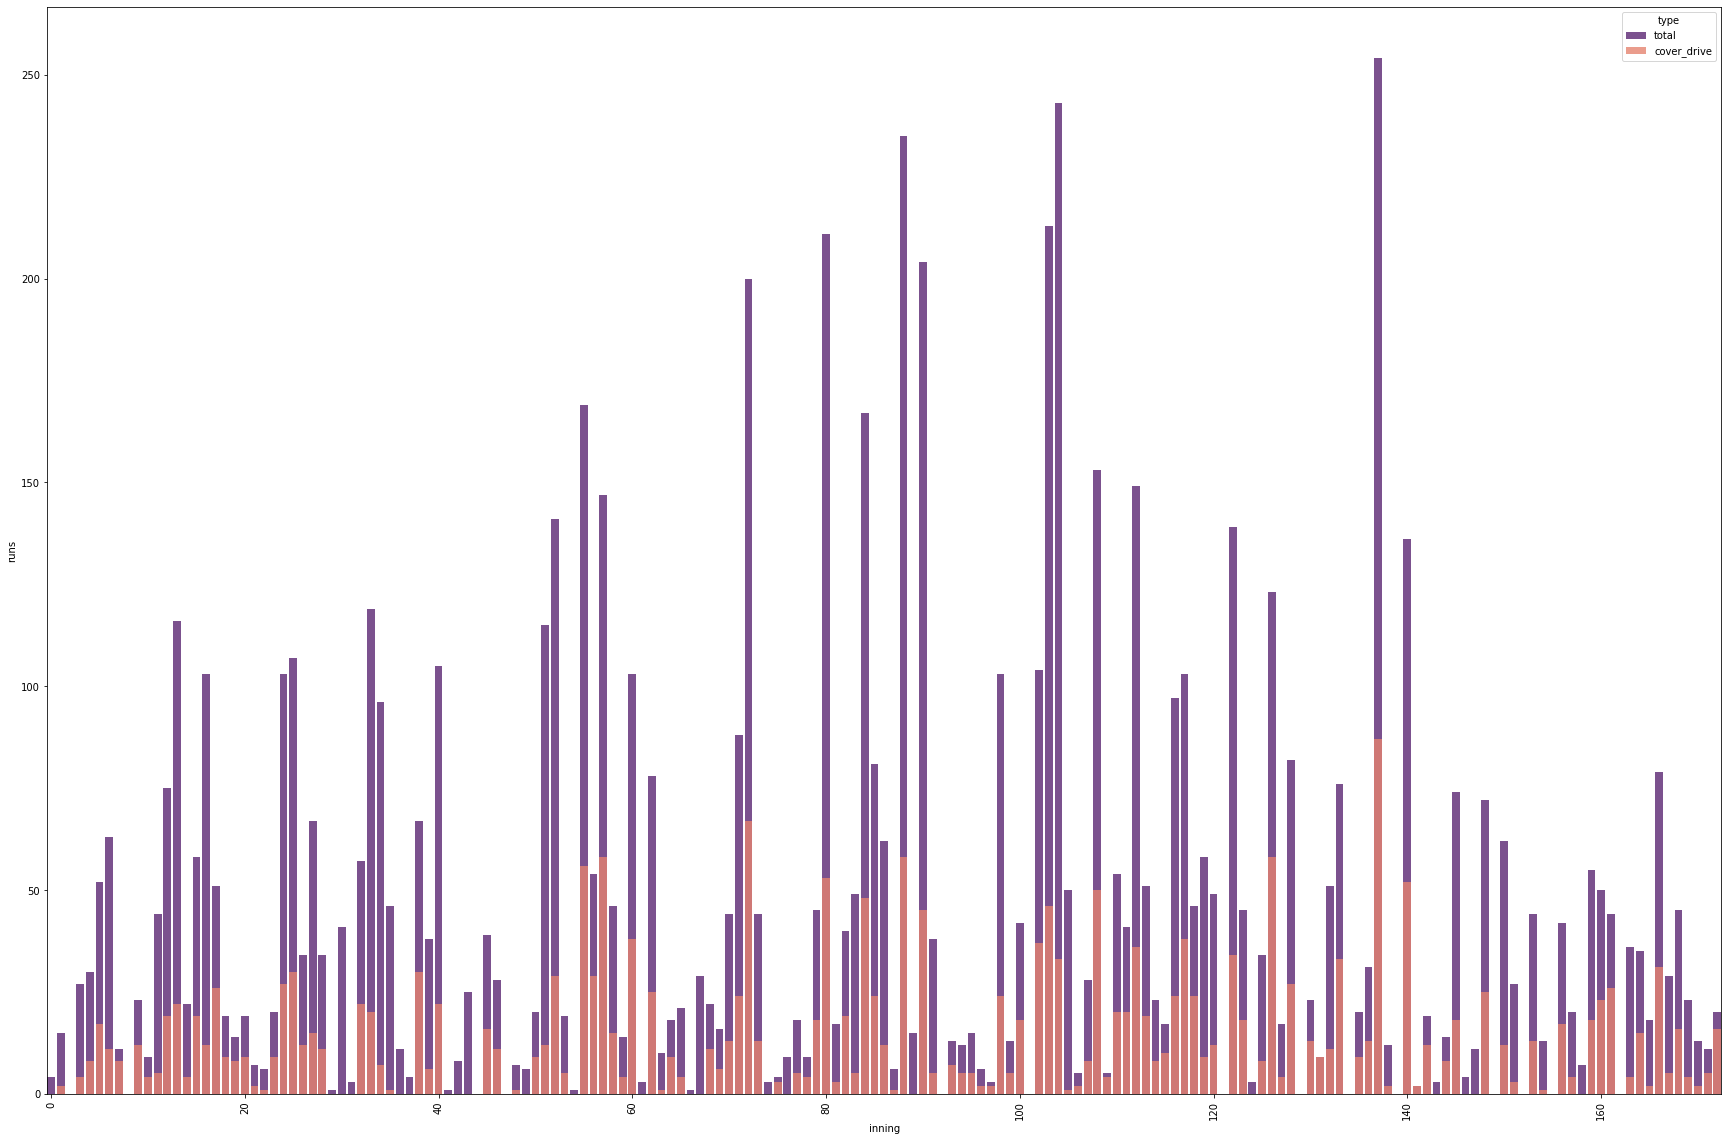

In [18]:
fig, ax1 = plt.subplots(figsize=(30,20)) 
#sns.set_theme()
colours = ['#5f187f','#f8765c']
custom = sns.set_palette(sns.color_palette(colours))
sns.barplot(data = runs_df, x=runs_df.inning, y=runs_df.runs, alpha=0.8, ax=ax1, palette=custom, hue=runs_df.type, dodge=False)
ax1.set_xticklabels(labels=[x for x in range(len(kohli_innings))], rotation=90);
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
ax1.margins(x=0)

Ok, so we cant really tell much of what is going on based on the graph, so maybe we can figure out what percentage or runs came off of cover drives and also what percentage of shots played (i.e. balls faced) were cover drives. And then we should also get a list of when the first cover drive was.


In [19]:
perc_runs_cd = []
for i in range(len(kohli_innings)):
    try:
        perc_runs_cd.append(round(int(kohli_cover_drive_stats[i]['runs'])/int(kohli_innings[i]['runs']), 2))
    except ZeroDivisionError:
        perc_runs_cd.append(0)

In [20]:
perc_runs_cd

[0.0,
 0.13,
 0,
 0.15,
 0.27,
 0.33,
 0.17,
 0.73,
 0,
 0.52,
 0.44,
 0.11,
 0.25,
 0.19,
 0.18,
 0.33,
 0.12,
 0.51,
 0.47,
 0.57,
 0.47,
 0.29,
 0.17,
 0.45,
 0.26,
 0.28,
 0.35,
 0.22,
 0.32,
 0.0,
 0.0,
 0.0,
 0.39,
 0.17,
 0.07,
 0.02,
 0.0,
 0.0,
 0.45,
 0.16,
 0.21,
 0.0,
 0.0,
 0.0,
 0,
 0.41,
 0.39,
 0,
 0.14,
 0.0,
 0.45,
 0.1,
 0.21,
 0.26,
 0.0,
 0.33,
 0.54,
 0.39,
 0.33,
 0.29,
 0.37,
 0.0,
 0.32,
 0.1,
 0.5,
 0.19,
 0.0,
 0.0,
 0.5,
 0.38,
 0.3,
 0.27,
 0.34,
 0.3,
 0.0,
 0.75,
 0.0,
 0.28,
 0.44,
 0.4,
 0.25,
 0.18,
 0.47,
 0.1,
 0.29,
 0.3,
 0.19,
 0.17,
 0.25,
 0.0,
 0.22,
 0.13,
 0,
 0.54,
 0.42,
 0.33,
 0.33,
 0.67,
 0.23,
 0.38,
 0.43,
 0,
 0.36,
 0.22,
 0.14,
 0.02,
 0.4,
 0.29,
 0.33,
 0.8,
 0.37,
 0.49,
 0.24,
 0.37,
 0.35,
 0.59,
 0.25,
 0.37,
 0.52,
 0.16,
 0.24,
 0,
 0.24,
 0.4,
 0.0,
 0.24,
 0.47,
 0.24,
 0.33,
 0,
 0.57,
 1.0,
 0.22,
 0.43,
 0,
 0.45,
 0.42,
 0.34,
 0.17,
 0,
 0.38,
 1.0,
 0.63,
 0.0,
 0.57,
 0.24,
 0.0,
 0.0,
 0.35,
 0,
 0.19,
 0.11,
 0,


In [24]:
def moving_average(nums, window_size=5):
    last_x_average = [None]*(window_size - 1)
    window_total = 0
    window_count = 0

    for i in range(len(nums)-window_size):
        last_x_average.append(round(sum(nums[i:i+window_size])/window_size, 5))

    return last_x_average

In [25]:
moving_runs_cd = moving_average(perc_runs_cd)

<AxesSubplot:>

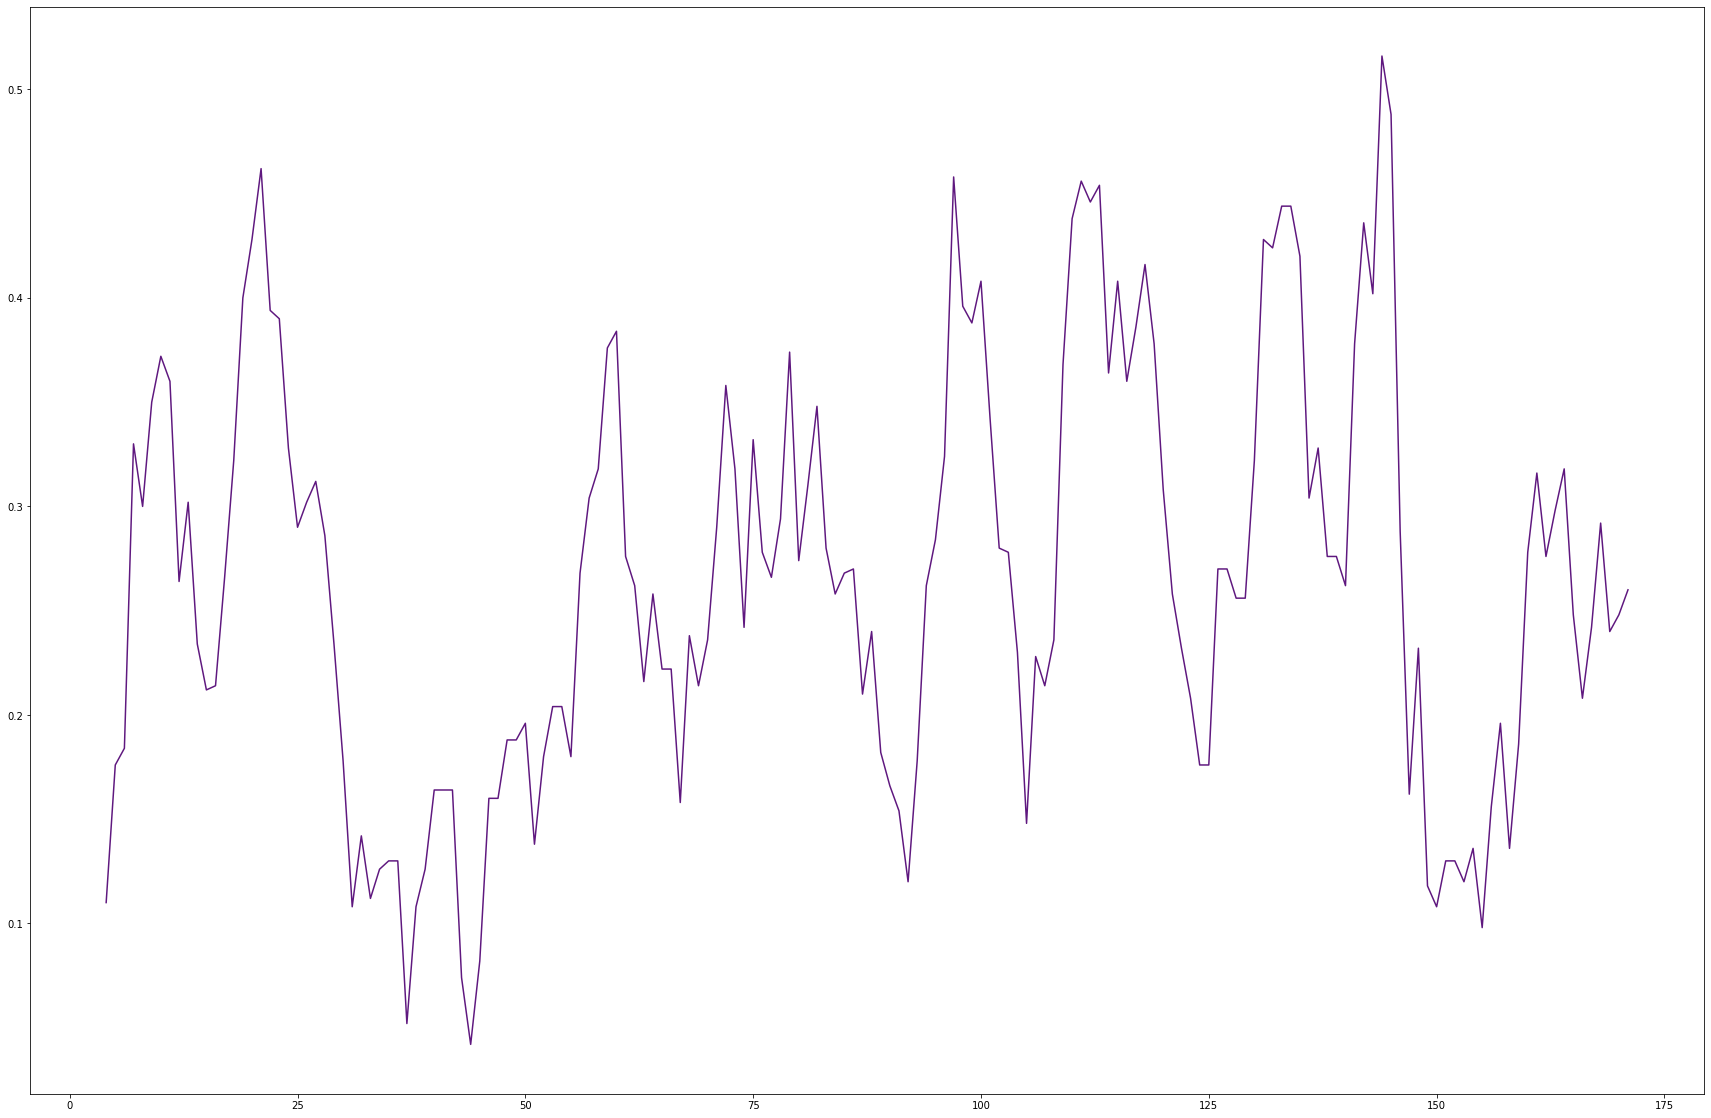

In [26]:
fig, ax1 = plt.subplots(figsize=(30,20)) 
sns.lineplot(x=list(range(len(moving_runs_cd))), y=moving_runs_cd)

### Percentage of Runs in innings off cover drives


<AxesSubplot:>

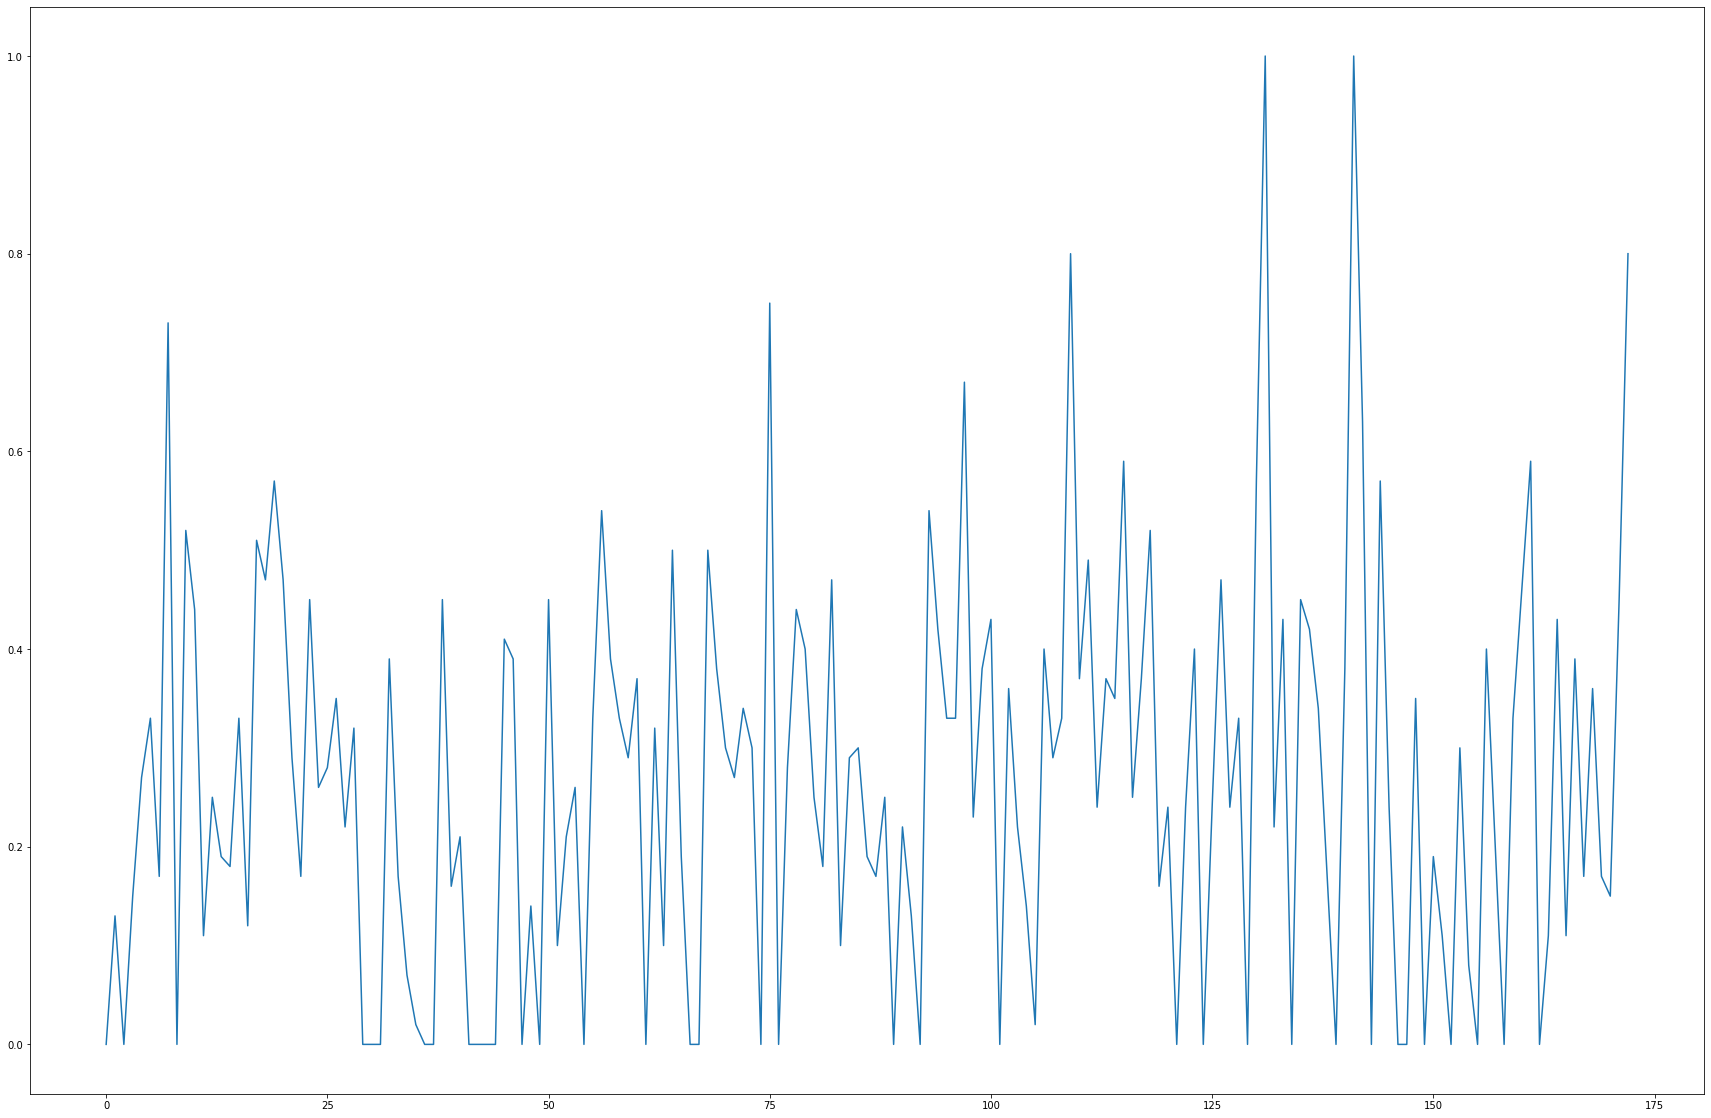

In [21]:
fig, ax1 = plt.subplots(figsize=(30,20)) 
sns.lineplot(x=list(range(len(perc_runs_cd))), y=perc_runs_cd)

No trend in runs scored off of cover drives and out of form period

In [26]:
perc_balls_cd = []
for i in range(len(kohli_innings)):
    try:
        perc_balls_cd.append(round(int(kohli_cover_drive_stats[i]['balls'])/int(kohli_innings[i]['balls_faced']), 2))
    except ZeroDivisionError:
        perc_balls_cd.append(0)

In [27]:
perc_balls_cd

[0.2,
 0.13,
 0.0,
 0.18,
 0.11,
 0.26,
 0.21,
 0.48,
 0.0,
 0.17,
 0.08,
 0.1,
 0.11,
 0.16,
 0.15,
 0.16,
 0.17,
 0.18,
 0.15,
 0.33,
 0.22,
 0.08,
 0.25,
 0.22,
 0.14,
 0.19,
 0.25,
 0.16,
 0.21,
 0.0,
 0.02,
 0.2,
 0.22,
 0.14,
 0.1,
 0.09,
 0.04,
 0.23,
 0.17,
 0.15,
 0.2,
 0.38,
 0.17,
 0.06,
 0.0,
 0.21,
 0.18,
 0.0,
 0.27,
 0.22,
 0.15,
 0.17,
 0.15,
 0.11,
 0.18,
 0.18,
 0.22,
 0.18,
 0.13,
 0.27,
 0.19,
 0.2,
 0.2,
 0.05,
 0.22,
 0.16,
 0.0,
 0.18,
 0.27,
 0.33,
 0.24,
 0.15,
 0.19,
 0.2,
 0.0,
 0.29,
 0.0,
 0.12,
 0.18,
 0.14,
 0.17,
 0.11,
 0.23,
 0.07,
 0.22,
 0.21,
 0.13,
 0.18,
 0.23,
 0.14,
 0.18,
 0.23,
 0.0,
 0.19,
 0.18,
 0.24,
 0.22,
 0.25,
 0.21,
 0.24,
 0.25,
 0.18,
 0.28,
 0.17,
 0.09,
 0.02,
 0.08,
 0.33,
 0.19,
 0.15,
 0.18,
 0.24,
 0.24,
 0.23,
 0.18,
 0.17,
 0.23,
 0.22,
 0.3,
 0.13,
 0.17,
 1.0,
 0.14,
 0.27,
 0.38,
 0.12,
 0.23,
 0.17,
 0.18,
 0.0,
 0.24,
 0.5,
 0.27,
 0.15,
 0.0,
 0.28,
 0.28,
 0.31,
 0.18,
 0.0,
 0.25,
 0.43,
 0.33,
 0.13,
 0.3,
 0.1,
 0.

### Percentage of balls where cover drives are played

<AxesSubplot:>

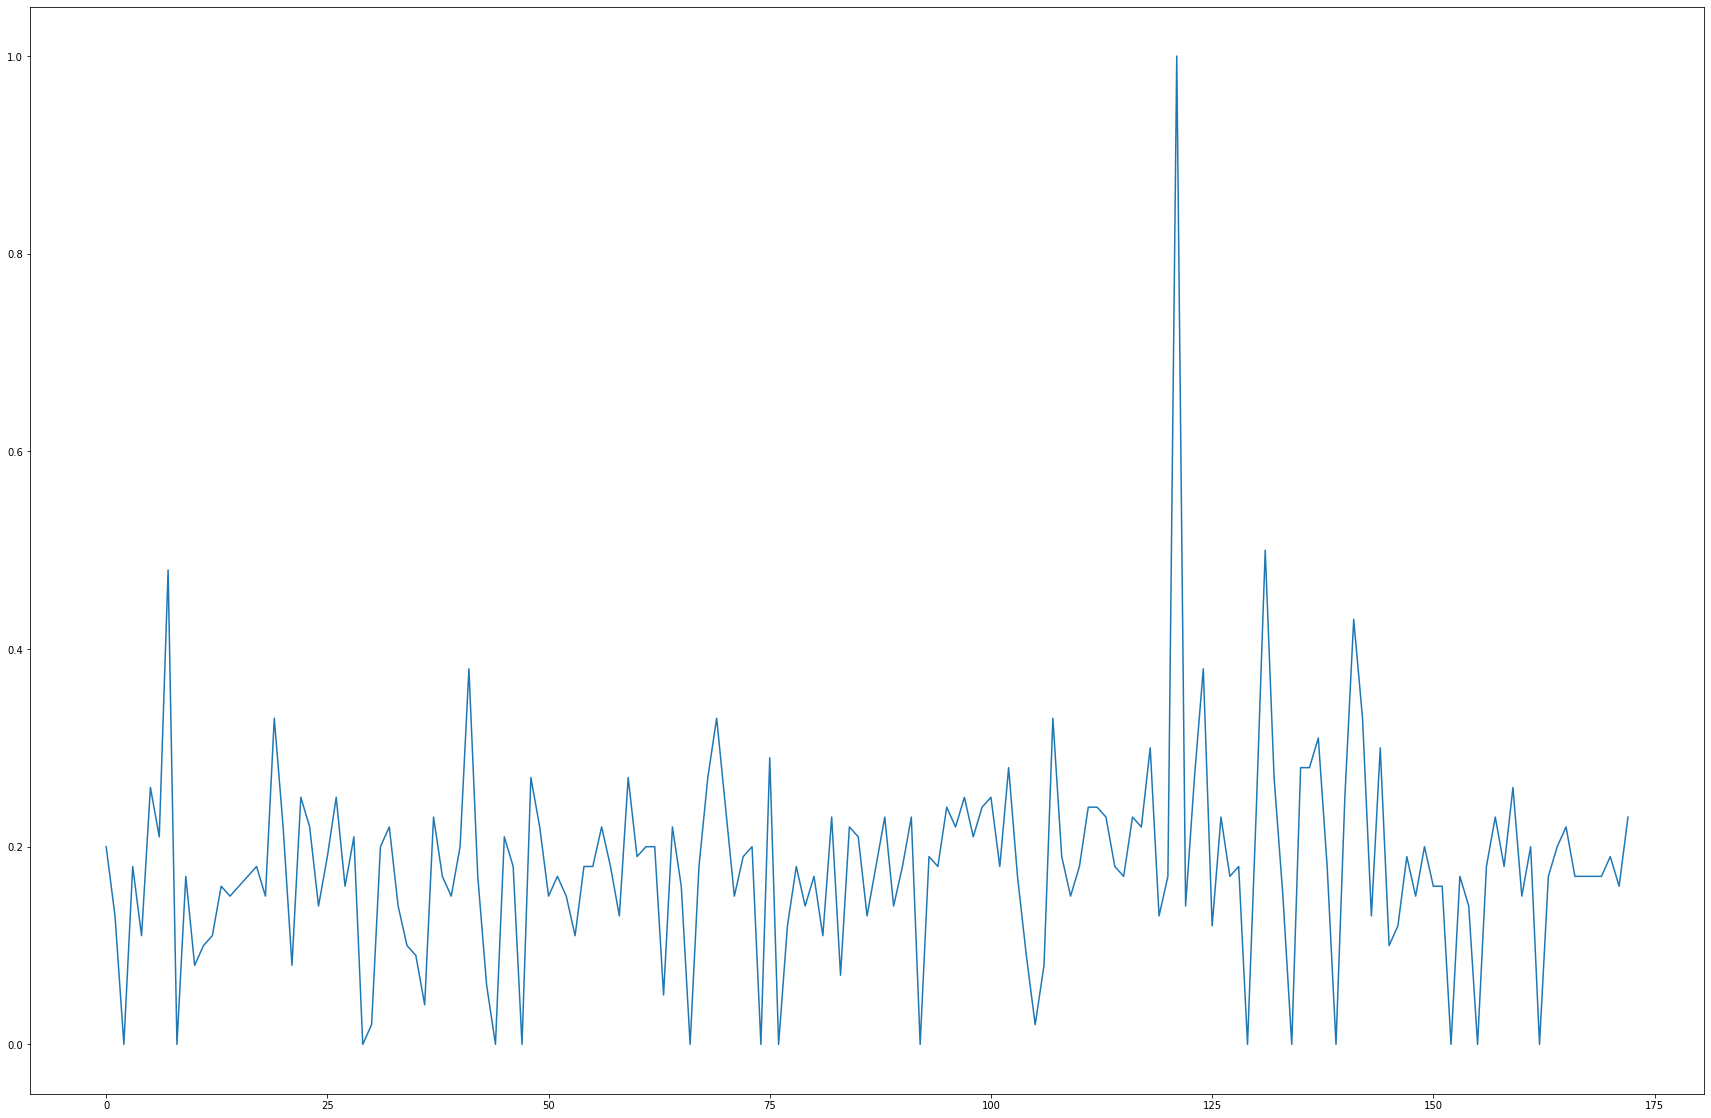

In [28]:
fig, ax1 = plt.subplots(figsize=(30,20)) 
sns.lineplot(x=list(range(len(perc_balls_cd))), y=perc_balls_cd)

No real trend here either. If anything, Kohli plays less cover drives when out of form, which is completely opposite to our hypothesis

In [29]:
first_drive = []
for inning in kohli_coverdrive_comms:
    try:
        first_drive.append(inning.iloc[0].batsmanBallsFaced)
    except IndexError:
        first_drive.append(0)

### The ball faced where the first drive was played in each inning

<AxesSubplot:>

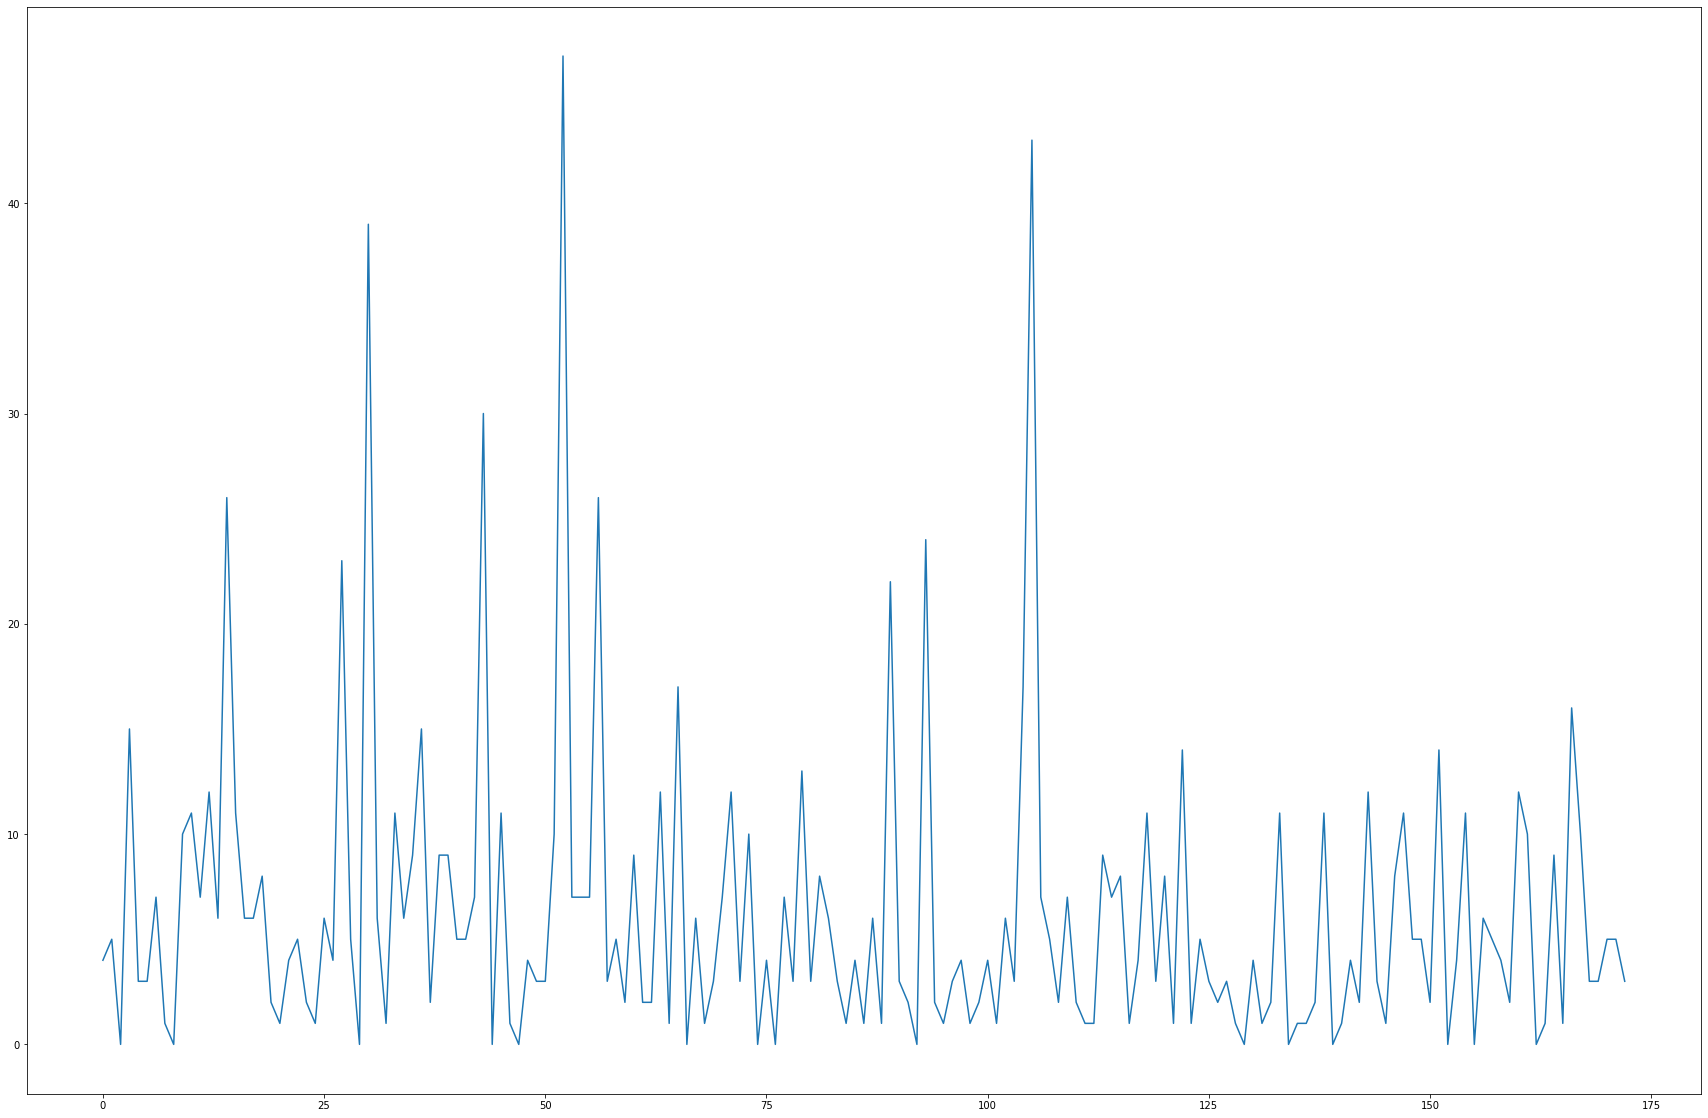

In [31]:
fig, ax1 = plt.subplots(figsize=(30,20)) 
sns.lineplot(x=list(range(len(first_drive))), y=first_drive)

Again, no real trend here. We can basically conclude that Kohli plays cover drives the same amount when in and out of form.
Here we can conclude that in fact, the reason for Virat's low form was not the shot choice per se, but it could have resulted as a lack of ability to _adapt_ when forma was poor. One of the most famous examples of this is Sachin Tendulkar's 241 against Australia where he only scored on one side of the wicket. This goes to show the adaptibility of Virat as a player. The best batsman of consistently adapt their game to the circumstances and to their form as well.

## Lets make a innings story graph

The goal will be to create an innings 'story'. The point of this is because we want to see what shot was played in each point of the innings. We often hear about how batsman 'build' innings, what doe this mean pratically? Usually when we talk about a batsman building their innings, we usually talk about how they are cautious at first, have a limited selection of shots, and then slowly start to expand their repitoir as they become more confident at the crease. The things to look out for then include:
- shot selection/range of shots played
- strike rate
- boundary rate
- control percentage

If we can map out these things, then we may be able to see how a batsman builds an innings. We can then also see how a batsman plays when in form and when out of form.

How will we visualize the innings?
- Strike rate: This can be a worm graph of the strike rate as the innings progresses
- Control percentage: we dont have a way to measure, but this would have been a percentage 
- Boundary Rate: boundaries per run scoring ball, and bar graph of total boundaries
- Shot selection, multi-coloured graph 

In [3]:
wsf.get_player_career_stats(KOHLI_ID)

{'bat_Span': '2011-2022',
 'bat_Mat': '102',
 'bat_Inns': '173',
 'bat_NO': '10',
 'bat_Runs': '8074',
 'bat_HS': '254*',
 'bat_Ave': '49.53',
 'bat_BF': '14499',
 'bat_SR': '55.68',
 'bat_100': '27',
 'bat_50': '28',
 'bat_0': '14',
 'bat_4s': '910',
 'bat_6s': '24',
 'bowl_Span': '2011-2022',
 'bowl_Mat': '102',
 'bowl_Inns': '11',
 'bowl_Overs': '29.1',
 'bowl_Mdns': '2',
 'bowl_Runs': '84',
 'bowl_Wkts': '0',
 'bowl_Econ': '2.88',
 'bowl_5': '0',
 'bowl_10': '0',
 'field_Span': '2011-2022',
 'field_Mat': '102',
 'field_Inns': '195',
 'field_Dis': '102',
 'field_Ct': '102',
 'field_St': '0',
 'field_Ct Wk': '0',
 'field_Ct Fi': '102',
 'field_MD': '3 (3ct 0st)',
 'field_D/I': '0.523'}

#### Dot ball percentages

Dot balls, are deliveries in the comms where there was no run scored. So lets get all of those

In [15]:
dot_ball_comms = []

for i, comms in enumerate(kohli_comms):
    dot_balls = comms[comms.batsmanRuns == 0]

    dot_ball_comms.append(dot_balls)

In [16]:
dot_ball_stats = [af.analyse_batting_inning(comms) for comms in dot_ball_comms]

In [17]:
perc_balls_dots = af.fraction_of_total(dot_ball_stats, kohli_innings, 'balls_faced')

In [18]:
moving_balls_dots = af.moving_average(perc_balls_dots)

<AxesSubplot:>

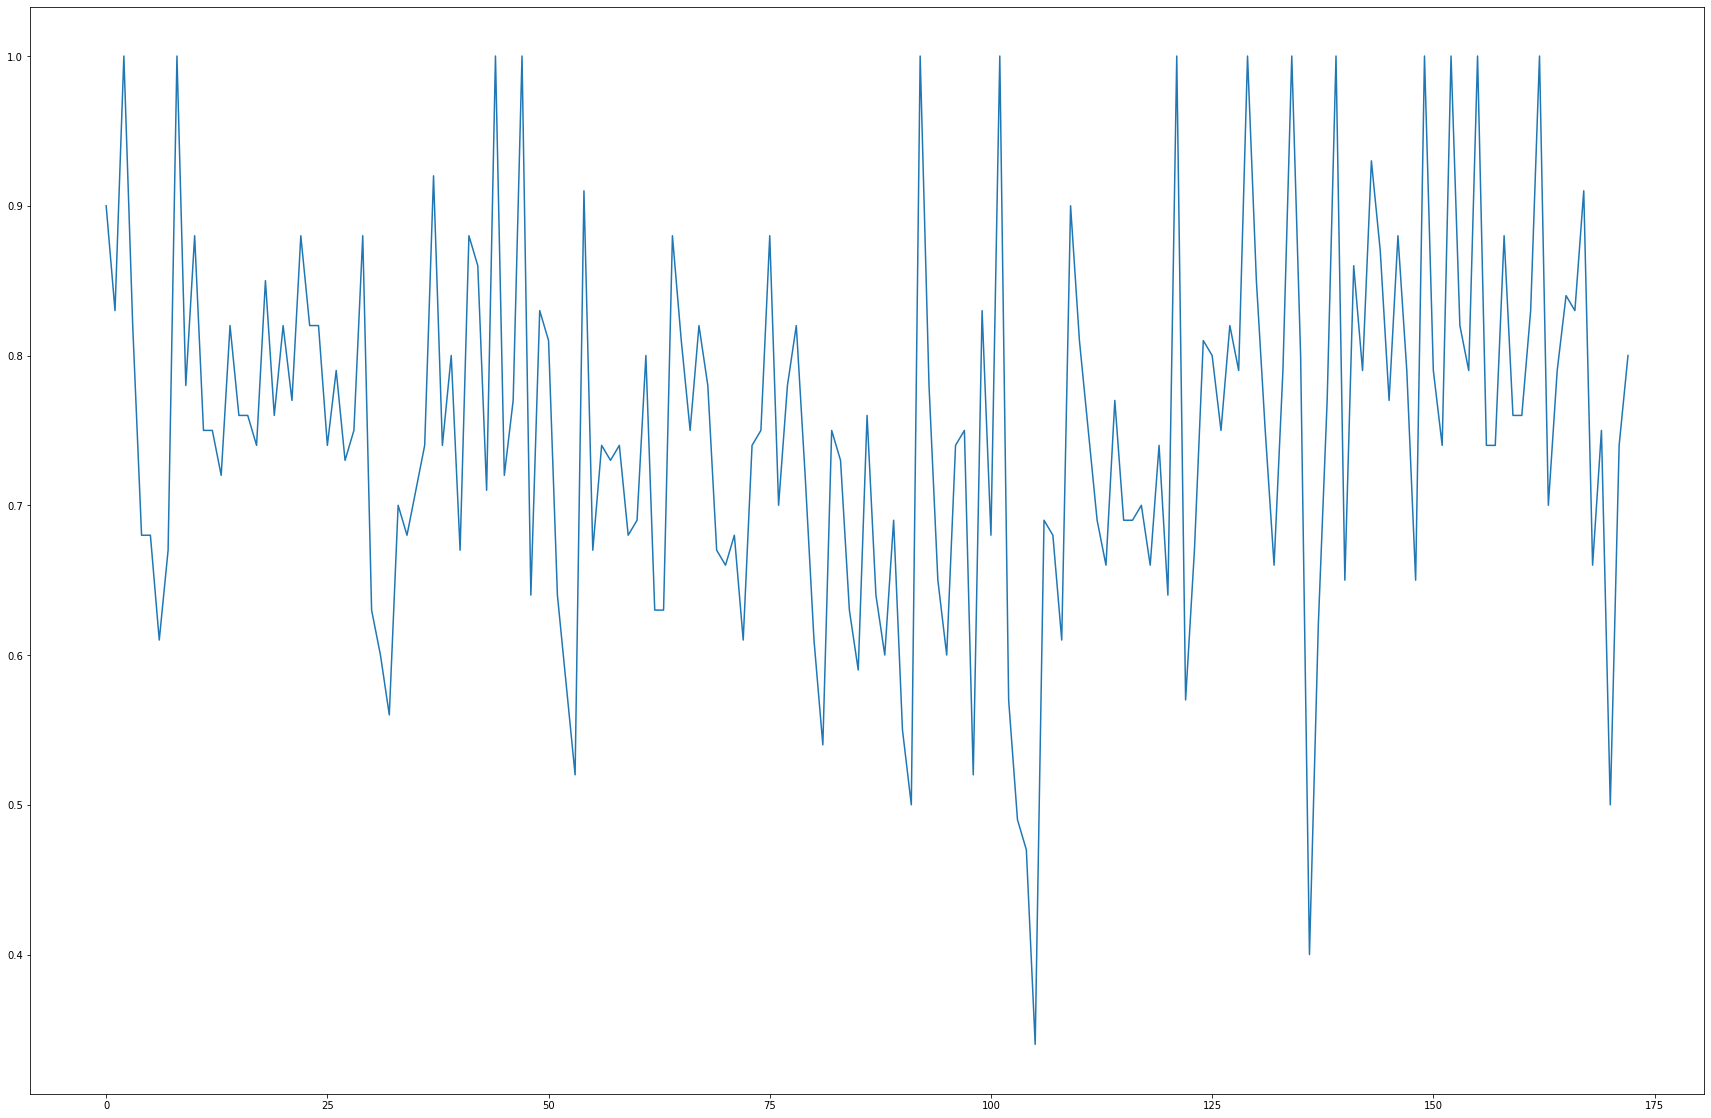

In [19]:
fig, ax1 = plt.subplots(figsize=(30,20)) 
sns.lineplot(x=list(range(len(perc_balls_dots))), y=perc_balls_dots)

<AxesSubplot:>

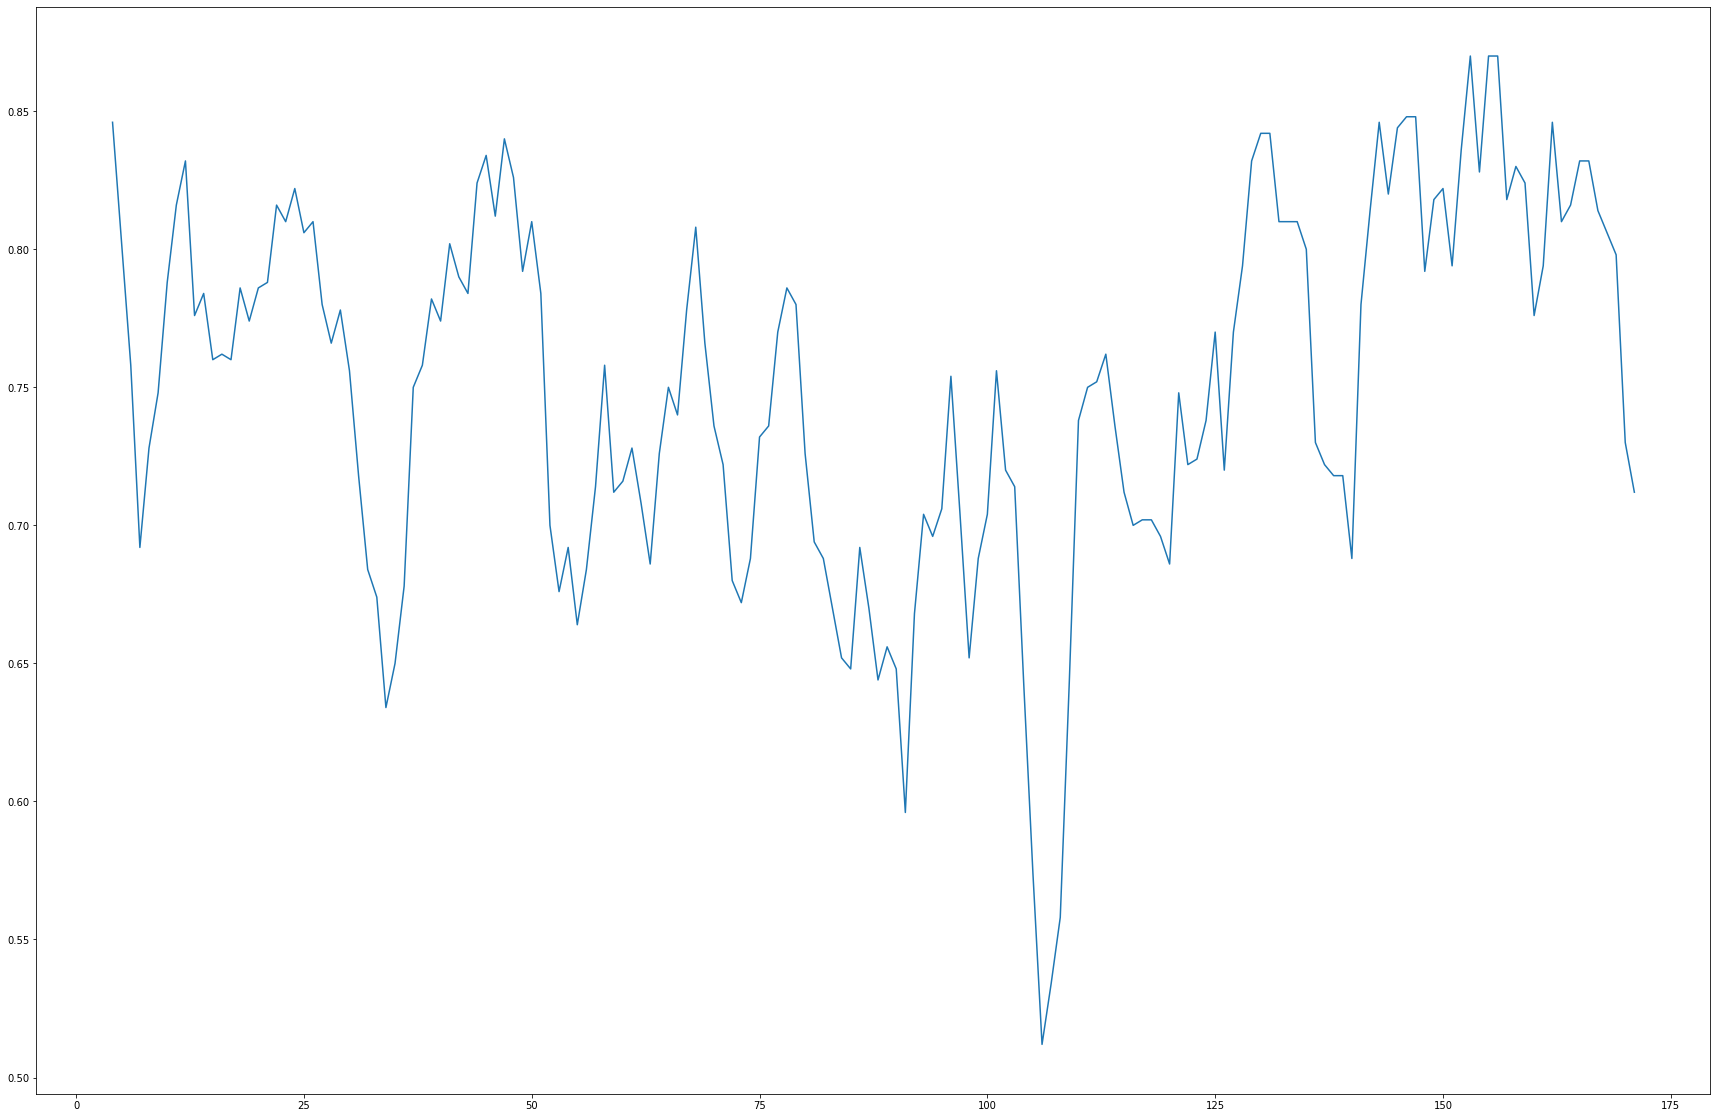

In [20]:
fig, ax1 = plt.subplots(figsize=(30,20)) 
sns.lineplot(x=list(range(len(moving_balls_dots))), y=moving_balls_dots)

In [21]:
moving_balls_dots_smooth = af.moving_average(perc_balls_dots, window_size=10)

<AxesSubplot:>

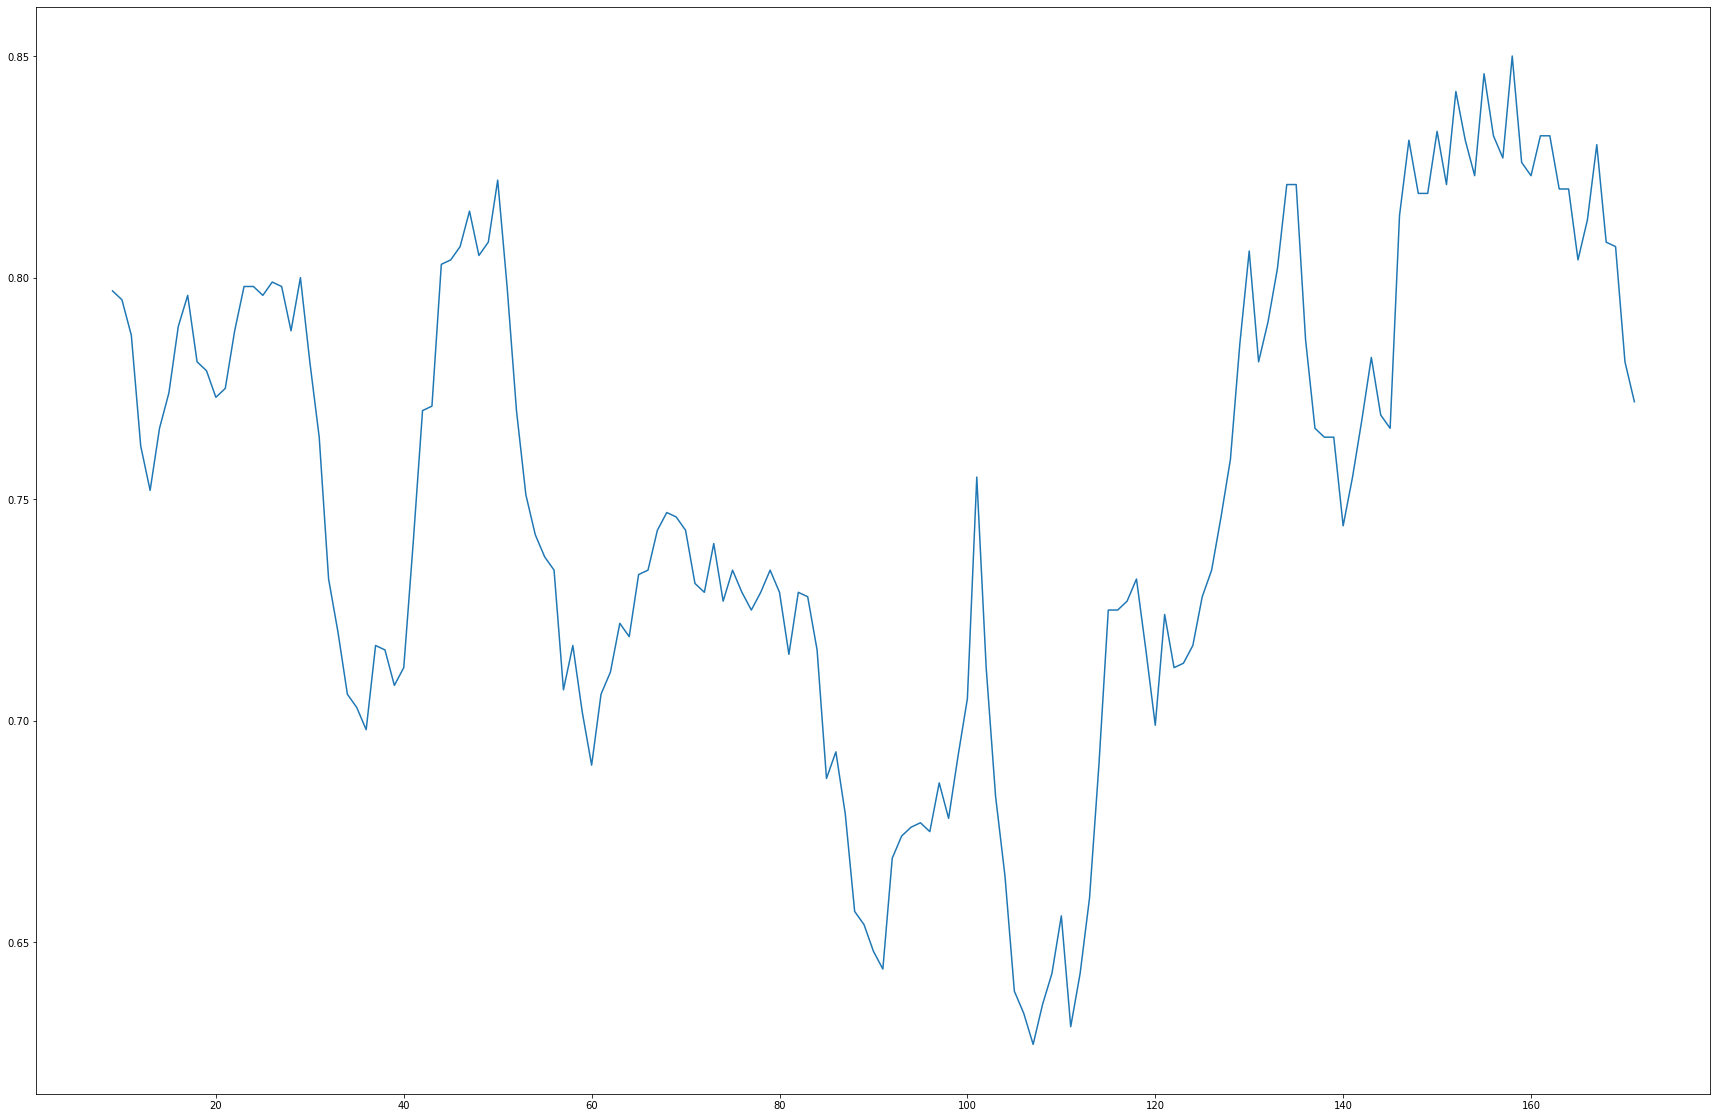

In [23]:
fig, ax1 = plt.subplots(figsize=(30,20)) 
sns.lineplot(x=list(range(len(moving_balls_dots_smooth))), y=moving_balls_dots_smooth)

Kohli is facing waaaaayyy more dot ball recently then his normal, and than his best form period. 85% of his balls now are dots compared to 75% in what looks like average, and also 65% what seems like is best. So basically Kohli is getting bogged down and is not flowing his runs as freely as he should. 

Actually one thing I want to explore, possible manually, is the commentary of the first few cove drives that Kohli is playing in every innings. I want to see if he is forcing the issue or not. Furthermore, lets quickly graph the total number of balls Kohli is facing per innings. Lets see if this average has dropped significantly.

#### Total number of balls per inning

In [24]:
total_balls_faced = [x['balls_faced'] for x in kohli_innings]

In [38]:
average_balls_faced = af.cumulative_average(total_balls_faced)

In [39]:
moving_average_balls_faced = af.moving_average(total_balls_faced, window_size=10)

<AxesSubplot:>

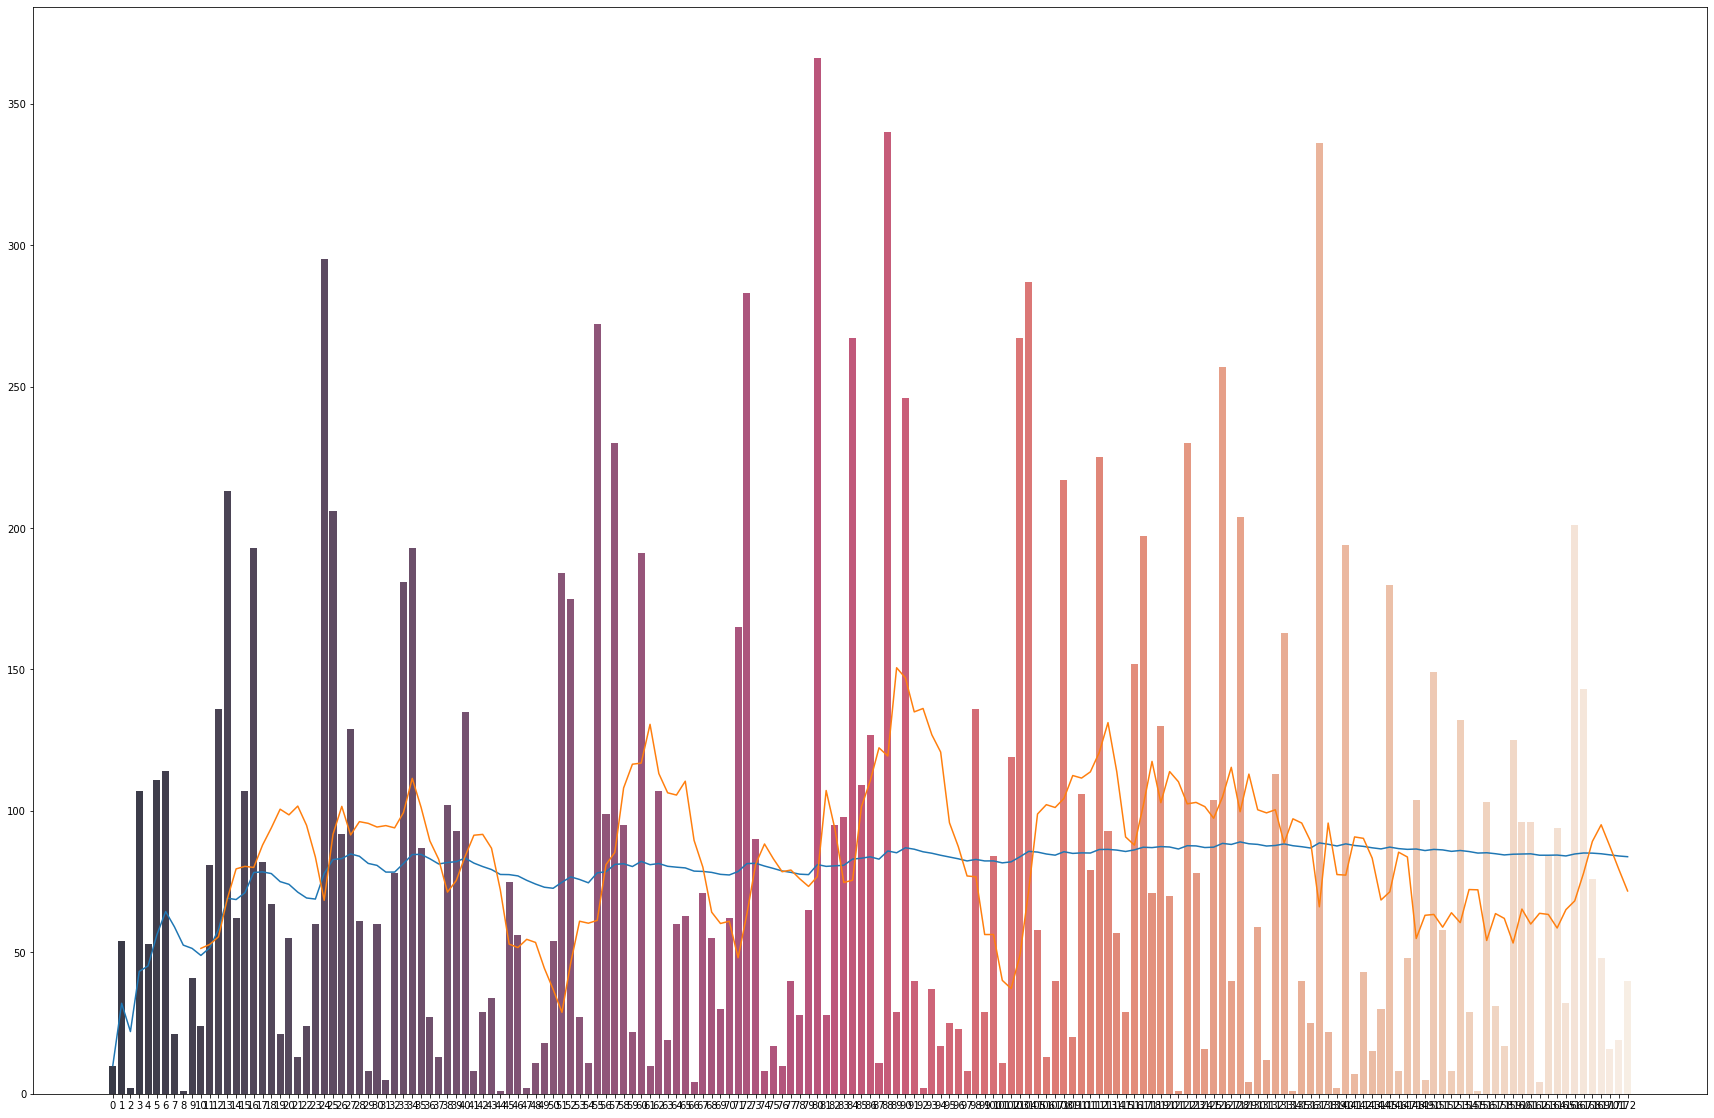

In [40]:
fig, ax1 = plt.subplots(figsize=(30,20)) 
sns.barplot(x=list(range(len(total_balls_faced))), y=total_balls_faced, alpha=0.8, ax=ax1, palette='rocket', dodge=False)
sns.lineplot(x=list(range(len(total_balls_faced))), y=average_balls_faced, ax=ax1)
sns.lineplot(x=list(range(len(total_balls_faced))), y=moving_average_balls_faced, ax=ax1)

The above graph is the average number of balls faced. We can see that it is going down in the period that is should be. 